<a href="https://colab.research.google.com/github/2pterons/multicampus/blob/main/3_1_20211005_KoGPT2_(oversampling)idiom_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
!nvidia-smi

Thu Oct  7 01:38:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **⦁ GPT** 구조

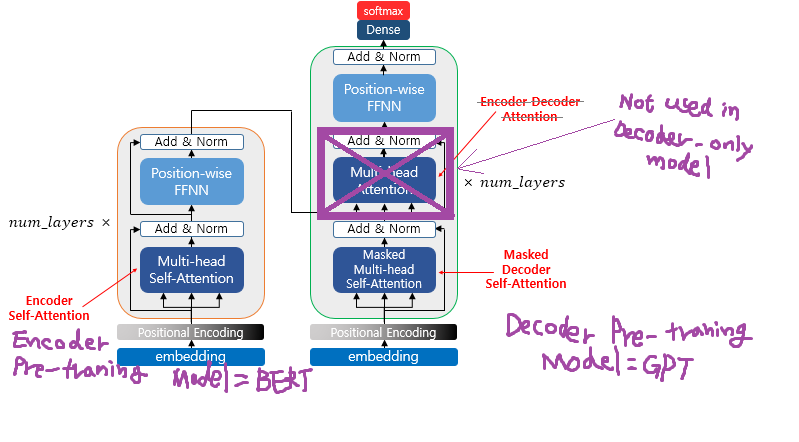

<br/><br/>

# **KoGPT2를 이용한 감성분석**
<br/>


### 1. 라이브러리 설치 및 임포트

In [24]:
%cd /content/drive/MyDrive/Colab Notebooks/multicampus/Idiom Classifier/data

/content/drive/MyDrive/Colab Notebooks/multicampus/Idiom Classifier/data


In [25]:
!pip install --upgrade mxnet>=1.6.0
!pip install gluonnlp
!pip install transformers
!pip install sentencepiece

import gluonnlp as nlp
from gluonnlp.data import SentencepieceTokenizer, SentencepieceDetokenizer
from transformers import TFGPT2LMHeadModel
import tensorflow as tf

import pandas as pd
import numpy as np
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
from tqdm import tqdm
import matplotlib.pyplot as plt


In [26]:
# oversampling을 위한 라이브러리 import - 설치도 해줄것!
!pip install imblearn
from imblearn.over_sampling import RandomOverSampler


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


<br/><br/>
### 2. pickle을 이용해 관용구문장(34614개)과 비관용구문장(30000개) 읽어오기 및 변수에 담기

In [27]:
import pickle
#with open('./final_idiom_dataset_for_ko.pkl', 'rb') as f:
with open('./3/train_34614.pkl','rb') as f:
  corpus = pickle.load(f)
with open('./3/no_idiom_30000.pkl','rb') as f:
  no_idiom = pickle.load(f)

In [28]:
# 관용구 문장만 가져와서 변수에 저장
corpus = corpus[corpus['Label']==1]
len(corpus), len(no_idiom)

(17307, 30000)

In [29]:
no_idiom.head()

ko  Label
0  최창식 구청장은 “동대문디자인플라자 완공에 맞춰 이 지역 일대의 간판을 깨끗이 정비...      0
1                            그와 함께 있는 것 자체가 행운이었습니다.      0
2  한국관광공사는 공사가 유치한 ‘홍콩 프루덴셜’ 임직원 1800명이 인센티브 관광 목...      0
3                            새로운 그대가 나에게 환하게 웃고 있군요.      0
4  이해관계가 걸린 법안 로비 성격을 전혀 띠지 않았으나, 이 가운데 일부는 2014년...      0

In [30]:
corpus.head()

ko  Label
0           그럼에도 불구하고 올림픽에서 가장 멋진 부분 중 하나는 바로 사진입니다.      1
4  이 자리에서 이 대표는 “일자리 문제가 어려운데 당에서도 민생연석회의 출범을 조만간...      1
5  한국이 당면한, 현대 한국의 정체성과 상처를 상징하는 특수한 것은 다름 아닌 ‘휴전...      1
6  전국 정부출연연구기관 지역조직 57개 관계자들이 지난 3월 6일 한자리 모여 지역혁...      1
8                                    내 휴가는 물 건너가는구나.      1

In [31]:
new_df = pd.concat([corpus, no_idiom])
new_df = new_df.sample(frac=1)
new_df.reset_index(drop=True, inplace=True)

In [32]:
new_df

ko  Label
0                       글을 시작하기에 앞서 분명히 짚고 넘어가야 할 것이 있다.      1
1      당신은 To-be 기준으로 카테고리를 확인하시고, 필요하신 경우 26일 이전에 다른...      0
2      특히 우리 측은 일본 초계기가 접촉한 레이더 주파수 특성(시간대·방위각 포함)을 공...      0
3                                   두고 보세요, 나는 그걸 출 거예요.      1
4                      당신으로부터 연락받고 함께 일하기를 학수고대하고 있겠습니다.      0
...                                                  ...    ...
47302  국가교육위원회 신설이 필요하다는 점에서 공청회가 진행됐지만 아직 논의가 안되고 있다...      0
47303  스페셜 MC로 참여한 딘딘 역시 “입을 다물 수 없는 충격을 받았지만 이런 이야기가...      1
47304                         하지만 처벌이 제대로 이루어지지 않고 있습니다.      0
47305                                   저는 공부를 먼저 해야 해요.      0
47306  내년 공군사관학교 여생도 경쟁률이 101.7대1로 처음으로 기록적인 세자릿수를 돌파했다.      0

[47307 rows x 2 columns]

In [33]:
#text.head()

In [34]:
#data = text['ko']
#data.head()

In [35]:
#target = text['Label']
#target.head()

In [36]:
#type(data)

In [37]:
type(new_df)

pandas.core.frame.DataFrame

<br/><br/> 
### 오버샘플링


In [38]:
# train, test 분리하는 작업 - train/val/test를 먼저 분리한 다음에 train에만 oversampling을 적용!
train, test = train_test_split(new_df, test_size=0.2, random_state=42)
train, val = train_test_split(train, test_size=0.1, random_state=42)

In [39]:
# oversampling 하는 코드
oversample = RandomOverSampler()
ko_t = train.ko.to_numpy().reshape(-1, 1) # to_numpy()로 해줘야함
label_t = train.Label.to_numpy().reshape(-1, 1)

x_over, y_over = oversample.fit_resample(ko_t, label_t)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [40]:
# x_over, y_over 개수가 동일해진걸 확인할 수 있음
len(x_over), len(y_over)

(43082, 43082)

In [41]:
# oversampling한 걸로 데이터프레임 다시 구성
#train = pd.DataFrame({'ko':x_over.reshape(-1),
#                      'Label':y_over.reshape(-1)})

<br/><br/> 
### 오버샘플링된 data/target(lable) 분리

In [42]:
#! oversampling한 걸로 데이터프레임 다시 구성
data = pd.DataFrame({'ko':x_over.reshape(-1)})
target = pd.DataFrame({'Label':y_over.reshape(-1)})

In [43]:
#!
data = data['ko']
target = target['Label']

In [44]:
len(data), len(target)

(43082, 43082)

In [45]:
### train dataset 구성
'''dataset = []
for text, label in zip(train.ko.to_list(), train.Label.to_list()):
  dataset.append([text, label])
dataset_train = dataset[:].copy()'''

'dataset = []\nfor text, label in zip(train.ko.to_list(), train.Label.to_list()):\n  dataset.append([text, label])\ndataset_train = dataset[:].copy()'

In [46]:
### validation dataset 구성
'''dataset_val = []
for text, label in zip(val.ko.to_list(), val.Label.to_list()):
  dataset_val.append([text, label])'''

'dataset_val = []\nfor text, label in zip(val.ko.to_list(), val.Label.to_list()):\n  dataset_val.append([text, label])'

In [47]:
###
#len(dataset_train), len(dataset_val)

<br/><br/>
### pre-training 


In [48]:
dx_train,dx_test, dy_train, dy_test = train_test_split(data, target, test_size=0.2, stratify=target, random_state=42)


In [49]:

MY_PATH = '/content/drive/MyDrive/Colab Notebooks/multicampus/Idiom Classifier/4.KoGPT2/'
MODEL_PATH = MY_PATH + 'gpt_ckpt'
TOKENIZER_PATH = MY_PATH + 'gpt_ckpt/gpt2_kor_tokenizer.spiece'

tokenizer = SentencepieceTokenizer(TOKENIZER_PATH, num_best=0, alpha=0)
detokenizer = SentencepieceDetokenizer(TOKENIZER_PATH)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(TOKENIZER_PATH,
                                               mask_token = None,
                                               sep_token = None,
                                               cls_token = None,
                                               unknown_token = '<unk>',
                                               padding_token = '<pad>',
                                               bos_token = '<s>',
                                               eos_token = '</s>')
# vocab --> Vocab(size=50000, unk="<unk>", reserved="['<pad>', '<s>', '</s>']")


In [50]:
MAX_LEN = 60
def build_data(x_data, y_label):
    data_sents = []
    data_labels = []

    for sent, label in zip(x_data, y_label):
        tokenized_text = vocab[tokenizer(sent)]

        tokens = [vocab[vocab.bos_token]]
        tokens += pad_sequences([tokenized_text], 
                                MAX_LEN, 
                                value=vocab[vocab.padding_token], 
                                padding='post').tolist()[0] 
        tokens += [vocab[vocab.eos_token]]

        data_sents.append(tokens)
        data_labels.append(label)

    return np.array(data_sents, dtype=np.int64), np.array(data_labels, dtype=np.int64).reshape(-1, 1)


In [51]:
x_train, y_train = build_data(dx_train, dy_train)
x_test, y_test = build_data(dx_test, dy_test)

x_train.shape, y_train.shape, x_test.shape, y_test.shape


((34465, 62), (34465, 1), (8617, 62), (8617, 1))

In [52]:
x_train

array([[    0,  6627, 28753, ...,     3,     3,     1],
       [    0,   183, 47568, ...,     3,     3,     1],
       [    0,   432,   171, ...,     3,     3,     1],
       ...,
       [    0,  8181, 30857, ...,     3,     3,     1],
       [    0,  4710, 48587, ...,     3,     3,     1],
       [    0,   167,  3255, ...,     3,     3,     1]])

In [53]:
x_test[0]


array([    0, 29306, 13096,  2236, 27790, 47627,  5898, 47558,   215,
         204, 47438,   148,  4013, 47440,     3,     3,     3,     3,
           3,     3,     3,     3,     3,     3,     3,     3,     3,
           3,     3,     3,     3,     3,     3,     3,     3,     3,
           3,     3,     3,     3,     3,     3,     3,     3,     3,
           3,     3,     3,     3,     3,     3,     3,     3,     3,
           3,     3,     3,     3,     3,     3,     3,     1])

In [54]:
len(x_test[0])

62

In [55]:
print(len(vocab))
print(vocab.padding_token, ':', vocab[vocab.padding_token])
print(vocab.bos_token, ': ', vocab[vocab.bos_token])
print(vocab.eos_token, ': ', vocab[vocab.eos_token])
print(vocab.unknown_token, ': ', vocab[vocab.unknown_token])


50000
<pad> : 3
<s> :  0
</s> :  1
<unk> :  5


In [56]:
word2idx = {k:v for k, v in vocab.token_to_idx.items()}
idx2word = {v:k for k, v in word2idx.items()}
idx2word[5000]


'▁전세'

In [57]:
# 참고 : https://nlp.gluon.ai/api/modules/data.html
tokenizer('나는 자연어처리를 공부하고 있다')

print([idx2word[i] for i in x_test[0]])

['<s>', '▁통근', '▁거리가', '▁너무', '▁머니', '까', '▁출근', '할', '▁때', '▁진', '이', '▁다', '▁빠져', '.', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '</s>']


In [58]:
gpt_model = TFGPT2LMHeadModel.from_pretrained(MODEL_PATH)
gpt_model.summary()


All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at /content/drive/MyDrive/Colab Notebooks/multicampus/Idiom Classifier/4.KoGPT2/gpt_ckpt.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


Model: "tfgp_t2lm_head_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
transformer (TFGPT2MainLayer multiple                  124242432 
Total params: 124,242,432
Trainable params: 124,242,432
Non-trainable params: 0
_________________________________________________________________


In [59]:
#pre-trainmodel
# TFGPT2MainLayer는 fine-tuning을 하지 않는다.
gpt_model.trainable = True
gpt_model.summary() # gtp_model을 다시 확인한다. trainable params = 0


Model: "tfgp_t2lm_head_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
transformer (TFGPT2MainLayer multiple                  124242432 
Total params: 124,242,432
Trainable params: 124,242,432
Non-trainable params: 0
_________________________________________________________________


In [60]:
# GPT2 입력
# ---------
x_input = Input(batch_shape = (None, MAX_LEN + 2), dtype = tf.int32)


In [61]:
# GPT2 출력
# ---------
# output_gpt[0]        --> <KerasTensor: shape=(None, 60, 50000) dtype=float32
# output_gpt[0][:, -1] --> <KerasTensor: shape=(None, 50000) dtype=float32
output_gpt = gpt_model(x_input)[0][:, -1]


In [62]:
# Downstream task : idiom classifier
# -------------------------------------
# 사전학습데이터 없이 Dense Layer만 붙여놓은것
y_output = Dense(1, activation = 'sigmoid')(output_gpt)
model = Model(x_input, y_output)
model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 2e-5))
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 62)]              0         
_________________________________________________________________
tfgp_t2lm_head_model (TFGPT2 TFCausalLMOutputWithPast( 124242432 
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 50000)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 50001     
Total params: 124,292,433
Trainable params: 124,292,433
Non-trainable params: 0
_________________________________________________________________


In [63]:
model2 = Model(x_input, y_output)

In [64]:
hist = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs=3, batch_size=32)

Epoch 1/3
1078/1078 [==============================] - 342s 305ms/step - loss: 0.3306 - val_loss: 0.1332
Epoch 2/3
1078/1078 [==============================] - 326s 303ms/step - loss: 0.1182 - val_loss: 0.0858
Epoch 3/3
1078/1078 [==============================] - 326s 302ms/step - loss: 0.0716 - val_loss: 0.0723


In [65]:
gpt_model.trainable = False
gpt_model.summary()

Model: "tfgp_t2lm_head_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
transformer (TFGPT2MainLayer multiple                  124242432 
Total params: 124,242,432
Trainable params: 0
Non-trainable params: 124,242,432
_________________________________________________________________


In [66]:
model = Model(x_input, y_output)
model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 1e-6))
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 62)]              0         
_________________________________________________________________
tfgp_t2lm_head_model (TFGPT2 TFCausalLMOutputWithPast( 124242432 
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 50000)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 50001     
Total params: 124,292,433
Trainable params: 50,001
Non-trainable params: 124,242,432
_________________________________________________________________


In [67]:
x_train

array([[    0,  6627, 28753, ...,     3,     3,     1],
       [    0,   183, 47568, ...,     3,     3,     1],
       [    0,   432,   171, ...,     3,     3,     1],
       ...,
       [    0,  8181, 30857, ...,     3,     3,     1],
       [    0,  4710, 48587, ...,     3,     3,     1],
       [    0,   167,  3255, ...,     3,     3,     1]])

In [68]:
hist = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs=3, batch_size=32)

Epoch 1/3
1078/1078 [==============================] - 144s 124ms/step - loss: 0.0435 - val_loss: 0.0780
Epoch 2/3
1078/1078 [==============================] - 132s 122ms/step - loss: 0.0440 - val_loss: 0.0773
Epoch 3/3
1078/1078 [==============================] - 132s 122ms/step - loss: 0.0434 - val_loss: 0.0756


<br/><br/> 
## 3/test_3000.pkl 테스트셋으로 테스트

In [69]:
# 새로운 문장으로 테스트
%cd /content/drive/MyDrive/Colab Notebooks/multicampus/Idiom Classifier/data/3/
f = open('test_3000.pkl', 'rb')
test = pickle.load(f)
len(test)

/content/drive/MyDrive/Colab Notebooks/multicampus/Idiom Classifier/data/3


3000

In [70]:
test.head()

ko  Label
0  더 큰 문제는 자영업자들이 상황을 타개하기 위해 부채를 확대하고 있어 잠재부실에 대...      0
1                      팝콘이랑 콜라 쓰레기는 버리고 오지 왜 들고 다니니?      0
2  삼성전자의 가시적인 목표는 파운드리 분야에서 대만 TSMC를 따라잡고, AP와 모뎀...      1
3  그런 만큼 이 시점에 우리 정부가 적극 개입해 북-미 사이에 다리를 놓는 것도 필요...      1
4  김 후보자는 개성공단 재개에 대한 원유철 자유한국당 의원의 질의에는 “지금 상황에서...      1

In [71]:
text, _ = build_data(test['ko'], np.zeros(len(test)))

# 시험 데이터로 학습 성능을 평가한다
pred = model.predict(text)
y_pred = np.where(pred > 0.5, 1, 0)
#new_accuracy = (new_y_pred == answer).mean()
#print("\nAccuracy = %.2f %s" % (accuracy * 100, '%'))

In [72]:
label = test['Label']

In [73]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
# 오차행렬
# 정확도
print("accuracy:", accuracy_score(label, y_pred))

# 정밀도
print("precision:", precision_score(label, y_pred))

# 재현율
print("recall:", recall_score(label, y_pred))

# f1-score
print("F1-Score:", f1_score(label, y_pred))

accuracy: 0.954
precision: 0.9552139037433155
recall: 0.9526666666666667
F1-Score: 0.9539385847797063


<br/><br/> 
# KCC940 데이터로 예측하기

In [80]:
# 새로운 문장으로 테스트
%cd /content/drive/MyDrive/Colab Notebooks/multicampus/Idiom Classifier/data/KCC/
f = open('KCC940_Korean_sentences_UTF8_V2.txt', 'r')
kcc = f.readlines()
len(kcc)

/content/drive/MyDrive/Colab Notebooks/multicampus/Idiom Classifier/data


6263454

In [81]:
final_kcc = []
for i in kcc:
  final_kcc.append(i.strip())

In [ ]:
#kcc_ko = pd.DataFrame(kcc, columns=['ko'])

In [82]:
kcc_ko = pd.DataFrame(final_kcc, columns=['ko'])

In [84]:
### 1차 모델저장
model.save('3_kogpt2_model')

INFO:tensorflow:Assets written to: 3_kogpt2_model/assets


INFO:tensorflow:Assets written to: 3_kogpt2_model/assets


In [85]:
kcc_ko_reshape, _ = build_data(kcc_ko['ko'], np.zeros(len(kcc_ko)))

# 시험 데이터로 학습 성능을 평가한다
kcc_pred = model.predict(kcc_ko_reshape)
kcc_y_pred = np.where(kcc_pred > 0.5, 1, 0)
#new_accuracy = (new_y_pred == answer).mean()
#print("\nAccuracy = %.2f %s" % (accuracy * 100, '%'))

In [86]:
### 모델저장
model.save('3_kogpt2_kcc_model')

INFO:tensorflow:Assets written to: 3_kogpt2_kcc_model/assets


INFO:tensorflow:Assets written to: 3_kogpt2_kcc_model/assets


In [87]:
# Label값 저장
with open('3_kogpt2_predY_6263454.pkl','wb') as f:
  pickle.dump(kcc_y_pred, f, pickle.HIGHEST_PROTOCOL)

In [88]:
# Label 불러오기
import pickle
with open('3_kogpt2_predY_6263454.pkl', 'rb') as f:
  kcc_label = pickle.load(f)

In [89]:
final_label=[]
for i in range(len(kcc_label)):
  final_label.append(kcc_label[i][0])


In [90]:
kcc_result = pd.DataFrame()
kcc_result['ko'] = kcc_ko['ko']
kcc_result['Label'] = final_label

In [91]:
kcc_result

ko  Label
0        뒤이어 자유한국당, 바른정당 순이었고, 국민의당과 정의당이 각각 4%, 없음·의견유...      0
1        다만 포럼을 중심으로 신당 창당도 가능하냐는 질문엔 "보수우파를 분열케 하는 행동은...      0
2        추미애 더불어민주당 대표는 "다른 건 다 좋아요. 그런데 제헌절에 유감이 있다는 대...      0
3        그는 "지역 유권자들이 자유한국당은 지구 상에 이런 야당은 유일할 거다, 희귀하고 ...      0
4                           이 위원장은 최우선 과제로 청년 취업난 해소를 꼽았다.      0
...                                                    ...    ...
6263449  기원전에는 페니키아 카르타고 로마의 침략을 받았고, 기원후에는 서고트와 아랍의 지배...      0
6263450        경남의 바다를 즐기기에는 거제시 남부면에 위치한 '명사 해수욕장'도 제격이다.      0
6263451                      과연 일본 3대 정원으로 꼽을만하다는 생각이 들었다.      0
6263452                         봉우리 사이가 짧아 시간은 20분도 안 걸린다.      0
6263453  5일 오후 2시에는 짐 홀트 세계축제협회 의장과 짐 터커 국제농업박람회협회 회장 등...      0

[6263454 rows x 2 columns]

In [92]:
###마지막 결과값 저장
with open('3_kogpt2_kcc_result.pkl', 'wb') as f:
  pickle.dump(kcc_result, f)

In [93]:
###결과값 불러오기
with open('3_kogpt2_kcc_result.pkl', 'rb') as f:
  kogpt2_kcc_result = pickle.load(f)

In [94]:
kcc_idiom = kogpt2_kcc_result[kogpt2_kcc_result['Label'] == 1]['ko']
len(kcc_idiom)

366236

In [101]:
kcc_no_idiom = kogpt2_kcc_result[kogpt2_kcc_result['Label'] == 0]['ko']

In [103]:
len(kcc_no_idiom)

5897218

In [95]:
with open('/3_kogpt2_kcc_idiom_result.pkl', 'wb') as f:
  pickle.dump(kcc_idiom, f)

<br/><br/> 
## 관용구로 분류된 데이터 확인


In [100]:
for i in kcc_idiom:
  print(i)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
14일 강병원 더불어민주당 원내대변인은 이날 현안 브리핑을 통해 "여야가 42일 만에 드디어 국회 정상화의 닻을 올렸다"며 이같이 말했다.
이 원장은 여당 의원들이 "북측과 협의해 표결을 결정한다는 발상에 대해 어떻게 생각하느냐"고 묻자 " 어처구니없 는 발상"이라고 말했다.
같은 당 정진석 의원은 "숙의 민주주의를 좋아하는 이 정부가 숙의는커녕 국무회의 심의도 거치지 않고 개헌안을 발표하고 있다"고 꼬집었다.
이날 추 대표는 이재명 후보의 개소식에서 이 후보야 말로 문재인 정부와 호흡을 잘 맞출 적임자라고 추켜세우며 당내 일부 '반 이재명' 정서 차단에 나섰다.
그는 "정치원로이자 양당 전·현직 당 대표로서 대한민국 정치의 품격을 올리고 올바른 정치문화를 만드는 데 앞장서도 모자를 마당에 참으로 유감이 아닐 수 없다"며 "양당 전·현직 당 대표의 막말 퍼레이드는 환경부 '블랙리스트' 이슈 등 최근 벌어지는 청와대발 악재 소식을 뒤로 돌리려는 의도가 아닌지 의심이 들 정도"라고 덧붙였다.
3선 그룹에선 "경험이 많은 박 원내대표에 대응하기 위해선 아예 젊은 세대가 나서야 한다"는 말이 나온다.
김대중 전 대통령의 3남인 김홍걸 더불어민주당 국민통합위원장이 "박근혜 전 대통령은 자신의 지지자가 목숨을 잃는 사태가 벌어져도 그들은 자신을 위한 소모품이라는 듯 웃는 모습으로 대중 앞에 나타나는 것으로 동정을 얻을 여지를 없애버렸다"며 박근혜 전 대통령을 비판했다.
30일 임 보좌관은 이날 자신의 페이스북에 법정구속된 김 지사를 향해 "경수야!"라고 부르며 "'정치 하지마라'던 노무현 대통령님의 유언이 다시 아프게 와서 꽂힌다"며 이같이 말했다.
강산에가 3살 때 세상을 뜬 아버지는 함경도 북청이 고향이고 어머니는 충청도 출신이지만 한국전쟁 전 함경도로 시집가 전쟁 전까지 그곳에서 산 것으로 알려졌다.
김종인 전 민주당 비상대책위 대표는 통화에서 "야당은 제대로 된 인사를 추천해야 하는 부담을 안게 됐고

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



통화정책과 관련된 경제 기사를 보면 자주 눈에 띄는 단어가 두 개 있습니다.
제도의 실효성에 대한 고민보다는 외형 치장에 신경 쓰다가 논란을 자초한 건 아닌지 되돌아보길 바란다.
5년이 더 지났으니 '억' 소리 나는 양육비는 그동안 늘었으면 늘었지 줄지는 않았을 겁니다.
권태신 한국경제연구원장은 "구조조정으로 일부 기업이 문을 닫거나 규모를 줄이면 기업의 투자 규모 등도 그만큼 쪼그라들 수밖에 없다"며 "수출·내수의 동반 부진으로 가뜩이나 기업의 경영 환경이 어려운 상황에서 구조조정이 진행됨에 따라 실물경제에도 악영향을 끼칠 가능성이 크다"라고 진단했다.
선발 주자인 저축은행도 발 빠르게 대응에 나섰다.
중국은 당분간 몸을 낮추고 신중하게 움직일 것으로 예상된다.
미국 연방준비제도가 20일 양적 완화 실험을 끝내는 첫걸음을 내디뎌서다.
보통 펀드는 과거 수익률을 찬찬히 보고 계속 오르겠다 싶은 곳에 투자하는 게 상식이건만, 순간 나는 상식도 근본도 없는 투자자란 자괴감이 들었다.
정부도 이를 모르는 바는 아니다.
내 주머니에서 나가는 게 아니니 신경 안 써도 된다고 생각하면 오산이다.
특히 눈에 띄는 부분은 소득 중에서 근로소득 소득 비중이 59%에 그치고 있다는 대목이다.
단도직입적으로 "요즘 뭐 하죠?" 외치자 돌아온 대답국내 자산시장에 수익성이 정체되면자산가들은 해외로 눈을 돌리게 됩니다.
월가에서 근무한 사람으로서 조금만 신경을 기울였다면 알 수 있는 일이었다.
무엇보다 오랜 세월 쌓아야 하는 노후자금은 물가상승을 고려해 현재 계산된 명목 금액보다 훨씬 많이 준비해야 낭패를 당하지 않는다.
주중 연장뿐만 아니라 일요일에도 문을 열 예정이다.
이에 따라 BMPS의 회생은 사실상 시장의 손을 떠났다.
김 교수에 대해서는 "저와 다소 다른 시각에서 정치경제를 바라보던 분이지만 이제 합리적 진보와 개혁적 보수가 손을 맞잡아야 한다고 생각한다"며 "우리 경제가 가야 할 길이 성장이냐 분배냐 이분법이 아니라 성장과 분배의 선순환에 있기 때문에 국민경제자문회의가 헌

KeyboardInterrupt: ignored

<br/><br/> 
## 비관용구로 분류된 데이터 확인

In [102]:
for i in kcc_no_idiom:
  print(i)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
그러면서 "검찰 조사에서 밝혀질 것"이라고 말했다.
김 후보자는 본인 재산을 '마이너스 1억2542만원'이라고 신고했다.
어려서 부모를 여읜 그는 제2차 세계대전이 한창인 1942년 중국 지린성 훈춘 위안소로 강제동원됐다.
심지어 한 중진 의원실엔 4번 찾아가고도 엇갈리자 오히려 의원실에서 연락이 와 다섯번 만에 만남이 성사된 적도 있다고 한다.
그러면서 "이번 사건의 본질은 곤경에 처한 범죄 혐의자가 자기 생존을 위해 국정을 뒤흔들어 보겠다고 벌인 삐뚤어진 일탈행위"라고 규정했다.
야 4당이 '적자국채 발행강요 의혹'을 정조준하며 대여 공동전선을 형성하고 있다.
이 관계자는 안 전 대표에 대한 출마 요구 목소리와 관련해 "우리에게 실제로 들려오는 이야기도 없다"라며 "관련해서 당에서도 오늘 아니라고 했다"라고 덧붙였다.
김성태 자유한국당 전 원내대표가 지난달 20일 서울 여의도 국회에서 국내 한 매체를 통해 자신의 딸 kt채용 비리 의혹이 불거진 것에 대해 kt 신입사원 기념사진 속 딸의 모습을 제시하며 명백한 허위사실이라 주장하고 있다.
또 특례업종에서 운수업이 제외될 것으로 보인다.
이명박 정부 시절 국가정보원이 주도한 '민간인 댓글조작' 등에 대한 수사가 진행 중인 가운데 전해철 더불어민주당 의원이 노무현 대통령 서거 전 '논두렁 시계' 등 과도하게 여론이 호도된 측면이 있었다며 실체적 진실을 밝혀야 한다고 주장했다.
제가 제 그 계정에 의한 법률상 피해자는 아니다.
이학재 의원과 박종진 전 앵커·신용한 전 충북지사 후보 등 과거 바른정당계 인사들이 잇따라 탈당하거나 한국당행을 택하면서 한국당 중심의 보수통합이 본격화될 것이란 관측이었다.
문재인 더불어민주당 대선후보가 17일 오전 대전 으능정이 문화의거리에서 유세차에 올라 지지를 호소하고 있다.
박광온 최고위원도 회의에서 "국가기밀 불법 탈취 사건의 진상은 명백하다"며 "비정상적인 방법으로 재정정보 비인가 영역에 접속해 국가 안위와 관련한

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
김 비대위원장은 노무현 정부 당시 정책실장과 부총리 겸 교육인적자원부 장관, 대통령자문 정책기획위원장을 역임했다.
경희대 총동문회는 11일 서울 중구 롯데호텔에서 열릴 예정인 총회에서 문 대통령 당선 축하연을 진행하며 축하패를 전달키로 했다.
이에 새누리당 조원진 원내수석부대표는 "국감을 차일피일 늦추려는 속셈을 이해할 수 없다"며 "기존의 잠정 합의를 지켜야 한다"고 반박했다.
이해찬 민주당 대표는 17일 오전 국회에서 열린 기자간담회에서 김 위원장의 토론제안에 응할 것이냐는 질문에 "출산주도성장이라는 경제학도, 사회학도 아닌 적절치 못한 용어를 쓰는 분들과 토론할 가치가 없다"고 단칼에 거절했다.
6.13 지방선거와 함께 치러지는 국회의원 재보궐 선거에서 배현진 전 MBC 아나운서가 자유한국당 서울 송파을 후보로 11일 공천 확정됐다.
이외에 운영인력 45명(연봉 5000만원)을 뽑는 '지역거점별 소통협력공간' 사업은 92억원에서 50억원으로, 혁신 코디네이터 60명(연봉 4300만원)을 채용하는 '국민참여 사회문제해결 프로젝트'는 140억원에서 90억원으로 각각 줄어들었다.
정부안에서 3조6000억원을 감액하고, 여야 협상으로 3조5000억원가량을 증액한 결과다.
문 대통령은 또 '김 위원장 서울 답방 때 한라산을 방문하면 정상에 헬기장이 없다'는 말에 대해선 "자연환경을 훼손하면서까지 헬기장을 만들면 논란이 될 것"이라고 말했다.
덕분에 새로운 풍속도가 조성될 조짐이다.
민주당 후보로 나온 정순균 강남구청장 당선인과 장영철 한국당 후보는 세곡동에서 각각 55.3%와 28.6%를 득표했다.
석영철 민중당 도당 위원장은 "경상도에서는 반대만 하는 사람을 농담으로 빨갱이 같다고 한다는 홍 대표의 변명은 민중당을 반대만 하는 집단으로 규정한 심각한 모욕"이라고 고발 배경을 설명했다.
또 나 의원은 지난 2015년 DMZ 목함지뢰사건 때, 이에 대응하기 위한 대북전단 살포에 반대했던 문 후보의 발언

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
16일 오후 경기도 수원시 경기도경제과학진흥원에서 열린 한국유치원총연합회 비상대책위원회 기자회견에서 이덕선 비대위원장이 취재진 질문에 답하고 있다.
안 의원과 우상호 더불어민주당 의원은 20일 tbs라디오 '김어준의 뉴스공장'에 출연해 민주당 당 대표와 한국당 비상대책위원장에 대해 의견를 나눴다.
국민 여러분께 감사드리고 민주당 당원 여러분들, 제가 언제나 여러분들 곁에 있다는 사실 다시 기억해 주시고 여러분들 제게 더 큰 힘 주시기 바랍니다.
민주당의 주축 중 하나인 86세대 출신인 우 의원은 지난해 원내대표 경선 1차 투표에서 1위를 차지한 바 있지만, 결선에서 7표 차이로 우상호 현 원내대표에게 역전패를 당했다.
중국산 당절임대추에서는 이산화황 기준의 5.8배가 검출됐다.
손 의원은 카페에서 차를 마시고 있던 사람들과 만나 "가끔씩 기도하면서 내가 왜 이런 길 가야 하나, 이런 데 왜서 있나 라고 생각했다"는 말로 최근의 힘겨운 심경을 토로했다.
김 후보는 2009년 5월 노무현 전 대통령 서거 사태 당시에도 두 사람의 만남이 이뤄졌다고 주장했다.
탄핵 소추안이 확실히 의결된다고 보기는 어려운 수준이다.
홍종학 중소벤처기업부 장관이 17일 서울 신대방동 소상공인연합회에서 열린 내년도 최저임금 인상 관련 간담회에서 발언하고 있다.
이 후보자가 의원 질의를 듣고 있다.
장기적인 제도 개선에 대해선 당정이 전문가 태스크포스팀을 꾸려 검토키로 했다.
김 원내대표는 이날 국회에서 열린 비상대책위원회국회의원 연석회의에서도"한반도 운명을 가를 이 민감한 남북관계 상황을 혼자 독자적으로 접근해 본인이 만나고 싶으면 만나고, 특사 보내고 싶으면 보내고, 18일 평양 간다며 국회에 비준동의안을 처리해 달라고 한다"며 비판의 목소리를 냈다.
하 최고위원은 "5.18 진상조사에 대한 바른정당의 확고한 의지를 보여주기 위해 광주를 찾았다"며 "통합보수선언이 관철될수 있도록 광주의 관심과 지지를 부탁한다"고 했다.


KeyboardInterrupt: ignored

In [ ]:
# 확인
cnt = 0
for i in kcc_idiom[cnt]:
  print(i)
  cnt += 1
  if cnt == 20:
    break

In [ ]:
### 모델로드
#model2.load_model('/3_kogpt2_model')
model2.load_weights('/3_kogpt2_kcc_model')

In [104]:
test_model = model2
test_model

In [107]:
!nvidia-smi

Thu Oct  7 09:35:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    33W / 250W |   8625MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [108]:
!ps aux | grep python

root          78  0.1  0.2 221520 58376 ?        Sl   01:06   0:55 /usr/bin/python2 /usr/local/bin/jupyter-notebook --ip="172.28.0.2" --port=9000 --FileContentsManager.root_dir="/" --MappingKernelManager.root_dir="/content"
root          91 15.3 77.3 49765692 20661908 ?   Ssl  01:27  75:08 /usr/bin/python3 -m ipykernel_launcher -f /root/.local/share/jupyter/runtime/kernel-5661fb64-77b1-4acb-a749-5a026bfe25f7.json
root         113  0.2  0.0 129688 15676 ?        Sl   01:27   1:15 /usr/bin/python3 /usr/local/lib/python3.7/dist-packages/debugpy/adapter --for-server 39325 --host 127.0.0.1 --port 23710 --server-access-token 3e7ab4f3bf8d8f5bdc9d40d79b87e4ad60f548d0ce5f64568b28f96d5b39d63a
root         291  0.0  0.0  18380  1980 ?        S    01:27   0:00 bash -c tail -n +0 -F "/root/.config/Google/DriveFS/Logs/drive_fs.txt" | python3 /opt/google/drive/drive-filter.py > "/root/.config/Google/DriveFS/Logs/timeouts.txt" 
root         293  0.0  0.0  31740  7948 ?        S    01:27   0:00 python3

<br/><br/> 
# KCC 150 / KCC q28 데이터로 예측하기

In [106]:
# 새로운 문장으로 테스트
%cd /content/drive/MyDrive/Colab Notebooks/multicampus/Idiom Classifier/data/KCC/
f = open('KCC150_Korean_sentences_UTF8.txt', 'r')
kcc150 = f.readlines()
len(kcc150)

/content/drive/MyDrive/Colab Notebooks/multicampus/Idiom Classifier/data/KCC


11961347

In [109]:
final_kcc150 = []
for i in kcc150:
  final_kcc150.append(i.strip())

In [ ]:
#kcc_ko = pd.DataFrame(kcc, columns=['ko'])

In [112]:
kcc150_ko = pd.DataFrame(final_kcc150, columns=['ko'])

In [118]:
len(kcc150_ko)

11961347

In [120]:
kcc150_ko_1 = kcc150_ko[:2500000]
kcc150_ko_2 = kcc150_ko[2500000:5000000]
kcc150_ko_3 = kcc150_ko[5000000:7500000]
kcc150_ko_4 = kcc150_ko[7500000:]

In [130]:
len(kcc150_ko_1)

2500000

# KCC150 1번 START

In [123]:
kcc_ko_reshape, _ = build_data(kcc150_ko_1['ko'], np.zeros(len(kcc150_ko_1)))

# 시험 데이터로 학습 성능을 평가한다
kcc_pred = model.predict(kcc_ko_reshape)
kcc_y_pred = np.where(kcc_pred > 0.5, 1, 0)
#new_accuracy = (new_y_pred == answer).mean()
#print("\nAccuracy = %.2f %s" % (accuracy * 100, '%'))

In [124]:
### 모델저장
#model.save('3_kogpt2_kcc150_1_model')

In [125]:
# Label값 저장
with open('3_kogpt2_kcc150_1_predY.pkl','wb') as f:
  pickle.dump(kcc_y_pred, f, pickle.HIGHEST_PROTOCOL)

In [126]:
# Label 불러오기
import pickle
with open('3_kogpt2_kcc150_1_predY.pkl', 'rb') as f:
  kcc150_1_label = pickle.load(f)

In [131]:
len(kcc150_1_label)

2500000

In [127]:
final_kcc150_1_label=[]
for i in range(len(kcc150_1_label)):
  final_kcc150_1_label.append(kcc150_1_label[i][0])


In [132]:
kcc150_1_result = pd.DataFrame()
kcc150_1_result['ko'] = kcc150_ko_1['ko']
kcc150_1_result['Label'] = final_kcc150_1_label

In [133]:
kcc150_1_result

ko  Label
0                               통합보건교육은 이 대학만의 특화된 프로그램이다.      0
1        이에 따라 전달된 후원금은 저소득층과 사회복지시설에 2억원 상당을, 중구 푸드뱅크 ...      0
2                            오리콤은 이에 모든 조직과 프로세스를 바꾸기로 했다.      0
3                 방사청은 이번 원가관리 안내서를 희망하는 기업에 무료로 배포할 예정이다.      0
4        그러나 이 건물은 겉에서 보는 것과는 달리 지어진 지가 꽤 오래되었는지 방이 약간 ...      0
...                                                    ...    ...
2499995  그 대신 그는 입속으로, 이링공 뎌링공 하야 나즈란 디내와손뎌 오리도 가리도 업슨 ...      0
2499996  가장 먼저 멀티피치 등반코스로 설악산 적벽과 장군봉, 별을 따는 소년들, 울산바위 ...      0
2499997  동부교육지원청은 총 26억5000여만원의 예산을 편성, 전년보다 2개교 증가된 34...      0
2499998  특히 오후 6시30분 시작될 야간 행진은 세종대로 사거리에서 동대문과 을지로3가 사...      0
2499999                         롯데의 밀리터리 유니폼은 지난해 다시 부활했다.      0

[2500000 rows x 2 columns]

In [134]:
###마지막 결과값 저장
with open('3_kogpt2_kcc150_1_result.pkl', 'wb') as f:
  pickle.dump(kcc150_1_result, f)

In [135]:
###결과값 불러오기
with open('3_kogpt2_kcc150_1_result.pkl', 'rb') as f:
  kogpt2_kcc150_1_result = pickle.load(f)

In [136]:
#250만개 데이터에서 관용구 14만5천개
kcc150_1_idiom = kogpt2_kcc150_1_result[kogpt2_kcc150_1_result['Label'] == 1]['ko']
len(kcc150_1_idiom)

145743

In [137]:
kcc150_1_no_idiom = kogpt2_kcc150_1_result[kogpt2_kcc150_1_result['Label'] == 0]['ko']

In [138]:
len(kcc150_1_no_idiom)

2354257

In [139]:
with open('/3_kogpt2_kcc150_1_idiom_result.pkl', 'wb') as f:
  pickle.dump(kcc150_1_idiom, f)

<br/><br/> 
## 관용구로 분류된 데이터 확인


In [ ]:
cnt=0
for i in kcc150_1_idiom:
  if cnt < 100:
    print(i)
    cnt+=1
  else:
    break

<br/><br/> 
## 비관용구로 분류된 데이터 확인

In [145]:
cnt=0
for i in kcc150_1_no_idiom:
  if cnt < 100:
    print(i)
    cnt+=1
  else:
    break

통합보건교육은 이 대학만의 특화된 프로그램이다.
이에 따라 전달된 후원금은 저소득층과 사회복지시설에 2억원 상당을, 중구 푸드뱅크 설립 지원에 6000만원, 저소득 긴급지원과 시설 등의 지원에 5000만원이 전해진다.
오리콤은 이에 모든 조직과 프로세스를 바꾸기로 했다.
방사청은 이번 원가관리 안내서를 희망하는 기업에 무료로 배포할 예정이다.
그러나 이 건물은 겉에서 보는 것과는 달리 지어진 지가 꽤 오래되었는지 방이 약간 낡았다는 느낌을 주었다.
그런데 황희찬이 다시 1부로 올라갈 수도 있다.
응답자 중 가장 많은 의견이었다.
P씨는 23일 오전 8시30분쯤 벤츠 승용차를 몰고 서울 마장동 내부순환로를 달리다 커브길에서 좌우 방호벽을 차례로 들이받았다.
니트는 당초 수능 영어를 2015년부터 대체할 계획이었지만 2019년까지 미뤄지는 등 난항을 겪어왔다.
세계 금융시장이 극심한 공포에서 잠시 벗어났다.
반면 글로벌 금융위기의 주범이었던 선진국의 살림살이는 크게 악화됐다.
경기도 체육회가 주최하고 경기도 및 가평군 태권도협회가 주관하는 이번 대회에는 도내 31개 시군 생활체육 동호인 2600여 명이 참가해 겨루기, 품세, 격파 종목에서 지역 및 개인의 명예를 빛내기 위해 한판 승부를 펼치게 된다.
사실 국내 업체들은 확장성에서 좋은 평가를 받고 있다.
군은 송기섭 군수의 지시로 작년 말 2017년 주요업무계획을 수립하면서, 기존 연도만 바꿔 소위 표지갈이 식으로 연례반복적으로 작성되던 업무계획에서 탈피, 수차례의 성과보고회 개최를 통한 성과와 과오점에 대한 철저한 분석을 통해 주요업무계획이 수립된바 있다.
웹접근성 인증은 한국정보화진흥원이 장애인이나 고령자도 편리하게 이용할 수 있도록 제작되고 관리하는 홈페이지에 부여합니다.
연예인으로는 방송인 김지민씨가 대표령 표창을, 방송인 최현정씨과 프로야구 선수 권혁이 국무총리표창을, 배우 김서형, 배우 김정은씨가 각각 금융위원장 표창을 받았다.
사실 실물경제의 붕괴를 걱정하는 정부의 속내는 구조조정이 약간 미흡하게 끝

---
<br/><br/><br/> 



# KCC150 2번 START

In [146]:
kcc_ko_reshape, _ = build_data(kcc150_ko_2['ko'], np.zeros(len(kcc150_ko_2)))

# 시험 데이터로 학습 성능을 평가한다
kcc_pred = model.predict(kcc_ko_reshape)
kcc_y_pred = np.where(kcc_pred > 0.5, 1, 0)
#new_accuracy = (new_y_pred == answer).mean()
#print("\nAccuracy = %.2f %s" % (accuracy * 100, '%'))

In [147]:
### 모델저장
#model.save('3_kogpt2_kcc150_1_model')

In [148]:
# Label값 저장
with open('3_kogpt2_kcc150_2_predY.pkl','wb') as f:
  pickle.dump(kcc_y_pred, f, pickle.HIGHEST_PROTOCOL)

In [149]:
# Label 불러오기
import pickle
with open('3_kogpt2_kcc150_2_predY.pkl', 'rb') as f:
  kcc150_2_label = pickle.load(f)

In [150]:
final_kcc150_2_label=[]
for i in range(len(kcc150_2_label)):
  final_kcc150_2_label.append(kcc150_2_label[i][0])


In [151]:
kcc150_2_result = pd.DataFrame()
kcc150_2_result['ko'] = kcc150_ko_2['ko']
kcc150_2_result['Label'] = final_kcc150_2_label

In [152]:
kcc150_2_result

ko  Label
2500000      북한은 1987년 대한항공기 폭파사건 이듬해 1월 테러지원국으로 지정된 바 있다.      0
2500001  또 4개의 지역영업부, 4개의 대형물류센터, 66개의 부품판매거점과 1300여개의 ...      0
2500002  기술과 경제의 관계를 다방면으로 탁월하게 분석한 이 책은 우리 삶과 일을 새로운 눈...      0
2500003  교육과학기술부와 한국과학창의재단은 대우증권의 교육기부 프로그램 개발 및 운영을 지원...      0
2500004  그러나 마스트리히트조약과 같이 EC의 근간에 대한 문제에 대해서는 정상회담의 합의를...      0
...                                                    ...    ...
4999995  사릉에서 미금시로 나가는 390번 지방도를 조금 나가다 보면 송릉교라는 작은 다리를...      0
4999996         홈팀 볼프스부르크는 경기 시작부터 강한 압박 플레이를 펼치며 공세에 나섰다.      0
4999997  실제로 인천은 올 시즌 엔트리에 든 23명 중 백업 골키퍼 조수혁을 제외한 22명이...      0
4999998  하지만 이에 맞섰던 김성훈은 155cm 남짓한 키로 아마 또래 선수 중에 최단신 선...      0
4999999  반면 집행부 업무가 1년 단위로 진행, 12월에 종료되는 상황에서 6월 행감시 연속...      0

[2500000 rows x 2 columns]

In [153]:
###마지막 결과값 저장
with open('3_kogpt2_kcc150_2_result.pkl', 'wb') as f:
  pickle.dump(kcc150_2_result, f)

In [154]:
###결과값 불러오기
with open('3_kogpt2_kcc150_2_result.pkl', 'rb') as f:
  kogpt2_kcc150_2_result = pickle.load(f)

In [155]:
kcc150_2_idiom = kogpt2_kcc150_2_result[kogpt2_kcc150_2_result['Label'] == 1]['ko']
len(kcc150_2_idiom)

143330

In [156]:
kcc150_2_no_idiom = kogpt2_kcc150_2_result[kogpt2_kcc150_2_result['Label'] == 0]['ko']

In [157]:
len(kcc150_2_no_idiom)

2356670

In [158]:
with open('/3_kogpt2_kcc150_2_idiom_result.pkl', 'wb') as f:
  pickle.dump(kcc150_2_idiom, f)

<br/><br/> 
## 관용구로 분류된 데이터 확인


In [159]:
cnt=0
for i in kcc150_2_idiom:
  if cnt < 100:
    print(i)
    cnt+=1
  else:
    break

이런 상황에서 손흥민이 비집고 들어갈 틈이 보이지 않는다.
그러면 한나라당과 이회창 후보는 또다시 역풍을 맞을 것이다.
농구단의 요구 사항을 거의 다 들어줘 통이 큰 전창진 감독조차 몸 둘 바를 모른다고 한다.
3회 잠시 숨을 고른 두 팀은 4회 들어 다시 타격감을 뽐냈다.
땀을 비 오듯 흘리며 더듬더듬 올라간 밀실에는 청년의 심장을 올려놓았다는, 다소 희화적으로 느껴지는 엉뚱한 얼굴의 돌 신상이 놓여 있었다.
역시 수비형 미드필더인 박용우는 왕성한 활동량에서 둘째가라면 서럽다.
경남이 방심할 경우 준비한 승격 전쟁에 마침표를 다음으로 미뤄야 할지도 모른다.
양측은 서로 엇박자를 내고 있다.
박선생한티 또 그런 짓 허는 날이면 고녀르 눈치코치 몰르는 대갱이를 내 숀으로 싹뚝 짤러 버리겄다고 말이지.
또 아들 블래키가 싫어하는 모차르트 악단까지 초청해 블래키의 속을 뒤집어 놓는다.
한강변을 조깅하는 에프의 모습이 눈에 선했다.
이에 이마트는 지난해 하반기 피코크 이탈리안, 피코크 프렌치 라인업을 발빠르게 신설해 피코크 키쉬와 크림브릴레, 타르트 등 10여 종 신제품을 선보였다.
이씨는 범행 이후인 5월16일 부산 소재 한 호텔에서 스스로 목숨을 끊으려다 실패한 뒤 112에 신고해 자수했다.
선망의 브라운관 속에서, 선택된 직업인으로서 스튜디오를 일터로 삼고 살다보면 그럴싸한 무대 뒤에는 내놓고 이야기하기 어려운 이야기들이 많이 일어남을 보고 듣는다.
북한 중국 쿠바 베트남을 제외한 세계의 누구도 고르바초프의 몰락을 바라지 않는다.
대만식 대왕 카스텔라 제조법을 지적한 먹거리 고발 프로그램으로 한 자영업자가 가게 문을 닫으면서 논란이 커지고 있다.
한국당 지도부는 앞서 바른정당 통합파와 물밑 접촉을 시도하며 군불 때기에 나서고 있다.
그렇게 제가 떠나온 골짜기로 돌아간 녀석이, 그 얼마 뒤, 늦장마가 한창일 때 형네 집을 다시 찾아왔더라는 얘기가 마을에 돌았다.
바깥에서의 몸은 상대방에게 폐를 끼치는 몸이고, 몸 아닌 것에 귀속되어야만 하는 불행한 몸이 되고 말았

<br/><br/> 
## 비관용구로 분류된 데이터 확인

In [160]:
cnt=0
for i in kcc150_2_no_idiom:
  if cnt < 100:
    print(i)
    cnt+=1
  else:
    break

북한은 1987년 대한항공기 폭파사건 이듬해 1월 테러지원국으로 지정된 바 있다.
또 4개의 지역영업부, 4개의 대형물류센터, 66개의 부품판매거점과 1300여개의 부품대리점을 운영하고 있다.
기술과 경제의 관계를 다방면으로 탁월하게 분석한 이 책은 우리 삶과 일을 새로운 눈으로 바라보게 해줄 것이다.
교육과학기술부와 한국과학창의재단은 대우증권의 교육기부 프로그램 개발 및 운영을 지원하는 한편 향후 교육기부 활동이 원활하게 추진될 수 있도록 적극 협력할 계획이다.
그러나 마스트리히트조약과 같이 EC의 근간에 대한 문제에 대해서는 정상회담의 합의를 근거로 하여 각국은 국민투표 및 의회의 비준을 받아야 한다.
청중 분석은 내용을 효과적으로 전달하기 위하여 반드시 거쳐야 할 단계로, 말하기의 준비 과정에서 이루어져야 한다.
월트디즈니 스튜디오가 12일 한국의 기자들에게 처음으로 스튜디오 내부를 공개해 미키마우스와 담비, 백설공주, 미녀와 야수가 태어난 그 꿈의 공장을 둘러볼 기회를 얻었다.
롯데 하우머치 자동차보험은 부부와 자녀 등 핵가족의 구성원이 저렴하게 자동차보험을 가입할 수 있도록 직계 2세대 대상 운전자 한정 특약을 국내 최초로 판매 중이다.
객관적인 전략에서 한 수 아래로 평가되는 레바논은 한국을 상대로 선수비 후역습 전술을 쓸 공산이 크다.
인터넷 게임에서 알게 된 남성의 금품을 훔친 30대 여성이 경찰에 붙잡혔다.
올해는 오는 10월까지 영암, 인제 등 모터스포츠 대회 개최지역을 중심으로 총 3번에 걸쳐 실시할 계획입니다.
한편 입주식날 강인규 나주시장과 지역 기관장 10여명이 나주 신청사를 방문해 첫 출근한 직원들에게 꽃을 나눠주며 환영했다.
그러나 나는 곧 돌아올 작정이다.
포르투갈도 유로 2016 본선행의 확정지었다.
일반적으로 시장금리 변동에 서서히 반응하는 잔액기준 코픽스와 달리 신규취급액기준 코픽스는 월 중 신규 조달 자금에 따라 산출되기 때문에 시장금리 변동에 더 민감합니다.
내 성적은 충청도 전체에서 몇 번째라고 들었다.
당신의 눈엔 내

---
<br/><br/><br/> 



# KCC150 3번 START

In [ ]:
kcc_ko_reshape, _ = build_data(kcc150_ko_3['ko'], np.zeros(len(kcc150_ko_3)))

# 시험 데이터로 학습 성능을 평가한다
kcc_pred = model.predict(kcc_ko_reshape)
kcc_y_pred = np.where(kcc_pred > 0.5, 1, 0)
#new_accuracy = (new_y_pred == answer).mean()
#print("\nAccuracy = %.2f %s" % (accuracy * 100, '%'))

In [ ]:
### 모델저장
#model.save('3_kogpt2_kcc150_1_model')

In [ ]:
# Label값 저장
with open('3_kogpt2_kcc150_3_predY.pkl','wb') as f:
  pickle.dump(kcc_y_pred, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# Label 불러오기
import pickle
with open('3_kogpt2_kcc150_3_predY.pkl', 'rb') as f:
  kcc150_3_label = pickle.load(f)

In [ ]:
final_kcc150_3_label=[]
for i in range(len(kcc150_3_label)):
  final_kcc150_3_label.append(kcc150_3_label[i][0])


In [ ]:
kcc150_3_result = pd.DataFrame()
kcc150_3_result['ko'] = kcc150_ko_3['ko']
kcc150_3_result['Label'] = final_kcc150_3_label

In [ ]:
kcc150_3_result

In [ ]:
###마지막 결과값 저장
with open('3_kogpt2_kcc150_3_result.pkl', 'wb') as f:
  pickle.dump(kcc150_3_result, f)

In [ ]:
###결과값 불러오기
with open('3_kogpt2_kcc150_3_result.pkl', 'rb') as f:
  kogpt2_kcc150_3_result = pickle.load(f)

In [ ]:
kcc150_3_idiom = kogpt2_kcc150_3_result[kogpt2_kcc150_3_result['Label'] == 1]['ko']
len(kcc150_3_idiom)

In [ ]:
kcc150_3_no_idiom = kogpt2_kcc150_3_result[kogpt2_kcc150_3_result['Label'] == 0]['ko']

In [ ]:
len(kcc150_3_no_idiom)

In [ ]:
with open('/3_kogpt2_kcc150_3_idiom_result.pkl', 'wb') as f:
  pickle.dump(kcc150_3_idiom, f)

In [ ]:
with open('/3_kogpt2_kcc150_3_no_idiom_result.pkl', 'wb') as f:
  pickle.dump(kcc150_3_no_idiom, f)

<br/><br/> 
## 관용구로 분류된 데이터 확인


In [ ]:
cnt=0
for i in kcc150_3_idiom:
  if cnt < 100:
    print(i)
    cnt+=1
  else:
    break

<br/><br/> 
## 비관용구로 분류된 데이터 확인

In [ ]:
cnt=0
for i in kcc150_3_no_idiom:
  if cnt < 100:
    print(i)
    cnt+=1
  else:
    break

---
<br/><br/><br/> 



# KCC150 4번 START

In [ ]:
kcc_ko_reshape, _ = build_data(kcc150_ko_4['ko'], np.zeros(len(kcc150_ko_4)))

# 시험 데이터로 학습 성능을 평가한다
kcc_pred = model.predict(kcc_ko_reshape)
kcc_y_pred = np.where(kcc_pred > 0.5, 1, 0)
#new_accuracy = (new_y_pred == answer).mean()
#print("\nAccuracy = %.2f %s" % (accuracy * 100, '%'))

In [ ]:
### 모델저장
#model.save('3_kogpt2_kcc150_1_model')

In [ ]:
# Label값 저장
with open('3_kogpt2_kcc150_4_predY.pkl','wb') as f:
  pickle.dump(kcc_y_pred, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# Label 불러오기
import pickle
with open('3_kogpt2_kcc150_4_predY.pkl', 'rb') as f:
  kcc150_4_label = pickle.load(f)

In [ ]:
final_kcc150_4_label=[]
for i in range(len(kcc150_4_label)):
  final_kcc150_4_label.append(kcc150_4_label[i][0])


In [ ]:
kcc150_4_result = pd.DataFrame()
kcc150_4_result['ko'] = kcc150_ko_4['ko']
kcc150_4_result['Label'] = final_kcc150_4_label

In [ ]:
kcc150_4_result

In [ ]:
###마지막 결과값 저장
with open('3_kogpt2_kcc150_4_result.pkl', 'wb') as f:
  pickle.dump(kcc150_4_result, f)

In [ ]:
###결과값 불러오기
with open('3_kogpt2_kcc150_4_result.pkl', 'rb') as f:
  kogpt2_kcc150_4_result = pickle.load(f)

In [ ]:
kcc150_4_idiom = kogpt2_kcc150_4_result[kogpt2_kcc150_4_result['Label'] == 1]['ko']
len(kcc150_4_idiom)

In [ ]:
kcc150_4_no_idiom = kogpt2_kcc150_4_result[kogpt2_kcc150_4_result['Label'] == 0]['ko']

In [ ]:
len(kcc150_4_no_idiom)

In [ ]:
with open('/3_kogpt2_kcc150_4_idiom_result.pkl', 'wb') as f:
  pickle.dump(kcc150_4_idiom, f)

In [ ]:
with open('/3_kogpt2_kcc150_4_no_idiom_result.pkl', 'wb') as f:
  pickle.dump(kcc150_4_no_idiom, f)

<br/><br/> 
## 관용구로 분류된 데이터 확인


In [ ]:
cnt=0
for i in kcc150_4_idiom:
  if cnt < 100:
    print(i)
    cnt+=1
  else:
    break


<br/><br/> 
## 비관용구로 분류된 데이터 확인

In [ ]:
cnt=0
for i in kcc150_4_no_idiom:
  if cnt < 100:
    print(i)
    cnt+=1
  else:
    break